In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append(r"/content/drive/MyDrive/")

Mounted at /content/drive


In [9]:
import os, json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [10]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor,SimplePreProcessor, PatchPreprocessor, MeanPreprocessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.nn.conv import FCHeadNet, AlexNet
from loader_util.callbacks import TrainingMonitor
from loader_util.io import HDF5DatasetGenerator
##
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam

In [11]:
# construct the training image generator
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode="nearest")

In [12]:
# load the RGB means for the train set
json_path = r"/content/drive/MyDrive/ImageDatasets/cats_dogs_hdf5/output/alexnet_dogs_vs_cats_mean.json"
train_path = r"/content/drive/MyDrive/ImageDatasets/cats_dogs_hdf5/train.hdf5"
valid_path = r"/content/drive/MyDrive/ImageDatasets/cats_dogs_hdf5/val.hdf5"
test_path = r"/content/drive/MyDrive/ImageDatasets/cats_dogs_hdf5/test.hdf5"
model_path = r"/content/drive/MyDrive/ImageDatasets/cats_dogs_hdf5/model"
outpath = r"/content/drive/MyDrive/ImageDatasets/cats_dogs_hdf5/output"
epochs = 75
batch_size = 128

means = json.loads(open(json_path).read())

# init the preprocessors
sp = SimplePreProcessor(227, 227)
pp = PatchPreprocessor(227, 227)
mp = MeanPreprocessor(means["R"], means["G"], means["B"])
iap = ImageToArrayPreprocessor()

In [13]:
traingen = HDF5DatasetGenerator(dbPath=train_path,
                                batchSize=batch_size,
                                preprocessors=[pp, mp, iap],
                                classes=2,
                                aug=aug)

validgen = HDF5DatasetGenerator(dbPath=valid_path,
                                batchSize=batch_size,
                                preprocessors=[sp, mp, iap],
                                classes=2)

In [14]:
# init the optimizer
print(f"[INFO] compiling model ......")
opt = Adam(learning_rate=0.001)
model = AlexNet.build(width=227,
                      height=227,
                      depth=3,
                      classes=2,
                      reg=0.0002)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# construct the set of callbacks
path = os.path.sep.join([outpath, f"{os.getpid()}.png"])
callbacks = [TrainingMonitor(path)]

[INFO] compiling model ......


In [16]:
H = model.fit_generator(traingen.generator(),
                        validation_data=validgen.generator(),
                        epochs=epochs,
                        max_queue_size=10,
                        callbacks=callbacks,
                        steps_per_epoch=traingen.numImages //batch_size,
                        validation_steps=validgen.numImages //batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/75
156/156 [==============================] - 690s 4s/step - loss: 3.2383 - accuracy: 0.5571 - val_loss: 2.7838 - val_accuracy: 0.5744
Epoch 2/75
156/156 [==============================] - 703s 5s/step - loss: 2.3521 - accuracy: 0.6269 - val_loss: 1.9419 - val_accuracy: 0.6669
Epoch 3/75
156/156 [==============================] - 698s 5s/step - loss: 1.7540 - accuracy: 0.6839 - val_loss: 1.5343 - val_accuracy: 0.6715
Epoch 4/75
156/156 [==============================] - 701s 5s/step - loss: 1.3843 - accuracy: 0.7165 - val_loss: 1.7034 - val_accuracy: 0.6172
Epoch 5/75
156/156 [==============================] - 705s 5s/step - loss: 1.1651 - accuracy: 0.7390 - val_loss: 1.1007 - val_accuracy: 0.7438
Epoch 6/75
156/156 [==============================] - 706s 5s/step - loss: 0.9755 - accuracy: 0.7736 - val_loss: 0.9154 - val_accuracy: 0.7603
Epoch 7/75
156/156 [==============================] - 705s 5s/step - loss: 0.8299 - accuracy: 0.8023 - val_loss: 0.7888 - val_accuracy: 0.7956

In [22]:
# save the model
model_path = r"/content/drive/MyDrive/ImageDatasets/cats_dogs_hdf5/model/saved_model/alexnet_dogs_cats.model"
print(f"[INFO] serialising the model......")
model.save(model_path, overwrite=True)

# close everything
traingen.close()
validgen.close()

[INFO] serialising the model......
INFO:tensorflow:Assets written to: /content/drive/MyDrive/ImageDatasets/cats_dogs_hdf5/model/saved_model/alexnet_dogs_cats.model/assets


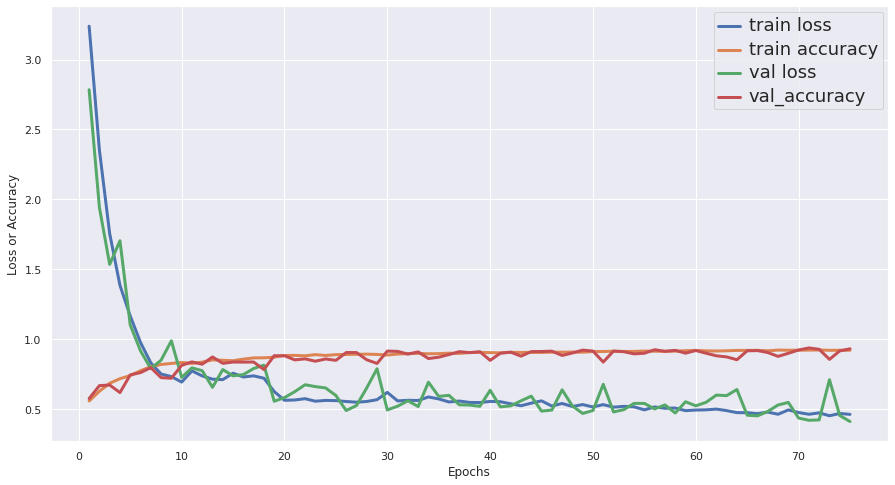

In [21]:


# plot the performance
epochs = range(1,75+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epochs,loss,accuracy,val_loss,val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text